# Z_ee Example for ATLAS xAOD Fileset
This notebook demonstrates the use of ServiceX and the _Coffea_ Local Executor to extract electron
data from an ATLAS Dataset and plot the mass of the Z Boson

In [1]:
from servicex import ServiceXDataset
from coffea.processor.servicex import DataSource, FuncAdlDataset, Analysis
from coffea.processor.servicex import LocalExecutor 

import matplotlib.pyplot as plt

from coffea import hist, processor
from IPython.display import display, update_display, HTML



## Specify the Dataset Identifier
The interface can easily process multiple datasets. Here we create a single one with the Rucio DID along with a backend 
specification that tells ServiceX these will be xAOD files

In [2]:
dids = ['mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00']
datasets = [
    ServiceXDataset(did, backend_type='xaod', ignore_cache=False)
    for did in dids
]

## Specify The Query
We will be using the [func_adl](https://github.com/iris-hep/func_adl_xAOD) language to specify the electron data we
want retrieved from the events along with a simple filter that only returns events with two electrons

In [3]:
leptons_per_event_query = FuncAdlDataset() \
        .Select(lambda e: e.Electrons("Electrons")) \
        .Select(lambda eles: eles.Where(lambda e: e.pt()/1000.0 > 30.0)) \
        .Select(lambda eles: eles.Where(lambda e: abs(e.eta()) < 2.5)) \
        .Where(lambda eles: len(eles) == 2) \
        .Select(lambda ls: (ls.Select(lambda e: e.pt()/1000.0), ls.Select(lambda e: e.eta()), ls.Select(lambda e: e.phi()), ls.Select(lambda e: e.m()/1000.0), ls.Select(lambda e: e.charge()))) \
        .AsROOTTTree('data.root', 'mytree', ('electrons_pt', 'electrons_eta', 'electrons_phi', 'electrons_mass', 'electrons_charge'))

In [4]:
datasource = DataSource(query=leptons_per_event_query, metadata={}, datasets=datasets)

## The Physics Code
We create a python function that simply accepts a _Coffea_ [NanoEvents](https://coffeateam.github.io/coffea/modules/coffea.nanoevents.html) instance that contains all of the events from a single 
root file out of the dataset. It returns a dict of histograms.

In this case `sumw` is the total number of events and `mass` is a historgram of the dielectron mass

In [5]:
class Z_EEAnalysis(Analysis):
    @staticmethod
    def process(events):
        import awkward as ak
        from collections import defaultdict

        sumw = defaultdict(float)
        mass_hist = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("mass", "$Z_{ee}$ [GeV]", 60, 60, 120),
        )

        dataset = events.metadata['dataset']
        electrons = events.electrons

        # Form the invar mass, plot.
        cut = (ak.num(electrons) == 2)
        diele = electrons[cut][:, 0] + electrons[cut][:, 1]

        sumw[dataset] += len(events)
        mass_hist.fill(
            dataset=dataset,
            mass=diele.mass,
        )
        
        return {
            "sumw": sumw,
            "mass": mass_hist
        }



## Create an Executor
We use an executor instance to receive the events streaming out of ServiceX and apply the analysis function. This is using 
the `LocalExecutor` which just runs on your local computer. There is support for Dask, FuncX, or Ray exectors.

In [12]:
analysis = Z_EEAnalysis()
executor = LocalExecutor()

## Run the Analysis and Dynamically Plot the Results
Create a little asynchronous function that awaits results from the analysis and updates a histogram plot

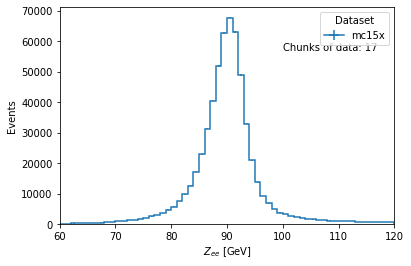

In [13]:
%matplotlib inline
async def plot_stream(accumulator_stream):
  global first
  fig, axes = plt.subplots()
  first = True


  count = 0
  async for coffea_info in accumulator_stream:
    hist.plot1d(coffea_info['mass'], ax=axes)

    count += 1
    plt.text(0.95, 0.8, f'Chunks of data: {count}', horizontalalignment='right', transform=axes.transAxes)

    # Either display it or update a previous version of the plot
    if first:
        display(fig, display_id='mass_update')
        first = False
    else:
        update_display(fig, display_id='mass_update')
  return coffea_info

await plot_stream(executor.execute(analysis, datasource))
plt.close()  # Prevents another copy of the plot showing up in the notebook